$\Large \text{Projects Technical Interview Code Workshop}$

In [2]:
import pandas as pd 
import numpy as np
import kagglehub
import random
import string
import spotipy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import time

/Users/tarunshah/Desktop/Venv VS/BDAB Fall' 25 Workshops/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$\text{Making the dataset - we're not going to go over this in our workshop, but you should definitly check it out at some point.}$

In [ ]:
path = kagglehub.dataset_download("sgoutami/spotify-streaming-history")
path = path + "/spotify_history.csv"

raw_data = pd.read_csv(path)
raw_data['ts'] = pd.to_datetime(raw_data['ts'])

load_dotenv()
client_id = os.getenv("CLIENT_ID_2")
client_secret = os.getenv("CLIENT_SECRET_2")
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
def generate_user_id(length):
    characters = string.ascii_letters + string.digits
    random_string = ''.join(random.choice(characters) for _ in range(length))
    return random_string

def assign_user_ids(df, user_id_labels):
    if len(user_id_labels) > len(df):
        user_id_labels = user_id_labels[:len(df)]
        df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
        df['userId'] = user_id_labels
        return df
    temp_user_id = generate_user_id(6)
    tracks = round(np.random.normal(loc=100, scale=20))
    user_id_labels.extend([temp_user_id for _ in range(tracks)])
    return assign_user_ids(df, user_id_labels)

def get_song_metadata(uris, sp):
    tracks_response = sp.tracks(uris)["tracks"]
    artist_ids = list({artist["id"] for track in tracks_response for artist in track["artists"]})
    artists_response = sp.artists(artist_ids)["artists"]
    artist_genre_map = {artist["id"]: artist.get("genres", "") for artist in artists_response}
    metadata_list = []
    for track in tracks_response:
        primary_artist = track["artists"][0]
        genres = artist_genre_map.get(primary_artist["id"], [])
        genre = genres[0] if genres else "" 

        metadata = {
            "track_name": track["name"],
            "artists": [artist["name"] for artist in track["artists"]],
            "album": track["album"]["name"],
            "release_date": track["album"]["release_date"],
            "genres": genre,
            "duration_ms": track["duration_ms"],
            "popularity": track["popularity"],
            "explicit": track["explicit"],
            "uri": track["uri"]
        }
        metadata_list.append(metadata)
    return metadata_list

new_dataset = assign_user_ids(raw_data, [])
new_dataset = new_dataset[["userId", "spotify_track_uri", "track_name", "ms_played", "ts"]]


In [ ]:
tracks = new_dataset['spotify_track_uri'].unique().tolist()
track_information = []

for start in range(0, len(tracks), 25):
    stop = min(start + 25, len(tracks))
    if start % 1000 == 0 and start != 0:
        print(f"Processed {start} songs. Pausing for 2 minutes to avoid going over Spotify's rate limits.")
        time.sleep(120) 
    uris = tracks[start:stop] 
    try:
        temp_info = get_song_metadata(uris, sp)
    except Exception as e:
        print(f"Didn't process batch {start} to {stop} due to error: {e}.")
        temp_info = []
    track_information.extend(temp_info)
    
saved_tracks_df = pd.DataFrame(track_information)
saved_tracks_df.to_csv("spotify_song_metadata", index=False)
new_dataset.to_csv("spotify_streaming_history.csv", index=False)


$\text{Let's start by exploring our datasets and cleaning them.}$

In [3]:
streaming_history = pd.read_csv("spotify_streaming_history.csv")
song_metadata = pd.read_csv("spotify_song_metadata.csv")

In [4]:
streaming_history.sort_values(by=['ts'], ascending=False).head(10)

,userId,spotify_track_uri,track_name,ms_played,ts
105015,BecInn,6iGU74CwXuT4XVepjc9Emf,God Only Knows - Mono,1893,2024-12-15 23:06:25
18664,LEpwKw,7peh6LUcdNPcMdrSH4JPsM,I Don't Trust Myself (With Loving You),1306,2024-12-15 23:06:23
110194,i4eHUU,0HHdujGjOZChTrl8lJWEIq,"Stop This Train - Live at the Nokia Theatre, L...",1283,2024-12-15 23:06:22
69265,2BWMlO,0qHMhBZqYb99yhX9BHcIkV,Magical Mystery Tour - Remastered 2009,1515,2024-12-15 23:06:21
127288,icRERt,4Fz1WWr5o0OrlIcZxcyZtK,On The Way Home,1247,2024-12-15 23:06:19
41303,cXT8Rm,52dm9op3rbfAkc1LGXgipW,Wild Horses - 2009 Mix,1562,2024-12-15 23:06:18
17858,Ud5Wm8,76CfWxdNh9k5ssABTxlmMJ,Eight Line Poem - 2015 Remaster,1375,2024-12-15 23:06:16
18535,7uUCEp,2BdBVq6So5sBCbALS2p1rR,I'm the Only Hell My Mama Ever Raised,4216,2024-12-15 23:06:15
126114,UpUdnP,1yxJyuOyBzOXbGDAZtT7BD,Who Cares,1342,2024-12-15 23:06:10
100326,YKxvIB,4GAhAw0RCzNVP976NRMOqO,Love Me Tender - From the 20th Century-Fox Cin...,1869,2024-12-15 23:06:09


In [5]:
song_metadata.head(10)

,track_name,artists,album,release_date,genres,duration_ms,popularity,explicit,uri
0,Here Comes The Sun - Remastered 2009,['The Beatles'],Abbey Road (Remastered),1969-09-26,classic rock,185733,82,False,spotify:track:6dGnYIeXmHdcikdzNNDMm2
1,Times Like These,"['Glen Campbell', 'Howard Willing', 'Julian Ra...",Meet Glen Campbell,2008-01-01,classic country,208240,32,False,spotify:track:5x3e3ycjCYXFskwfNgNhaz
2,Alone Together,['Fall Out Boy'],Save Rock And Roll,2013-04-12,emo,203413,60,False,spotify:track:5MsZIaCYY6Tsdph0LiB0hE
3,Memories,['Maroon 5'],Memories,2019-09-20,pop,189486,32,False,spotify:track:2b8fOow8UzyDFAE27YhOZM
4,In the Flesh?,['Pink Floyd'],The Wall,1979-11-30,progressive rock,198221,59,False,spotify:track:24YmWQgunJGAU8El3ndkyn
5,I Found a Reason - 2015 Remaster,['The Velvet Underground'],Loaded (2015 Remaster),1970,proto-punk,255680,52,False,spotify:track:63OJHHu2ambZAvdrvhdT2b
6,Eleanor Put Your Boots On,['Franz Ferdinand'],You Could Have It So Much Better,2005-10-03,indie rock,169933,41,False,spotify:track:24AFErHUiORpll04wrR6u4
7,Diggin' My Grave,"['Lady Gaga', 'Bradley Cooper']",A Star Is Born Soundtrack (Without Dialogue),2018-10-05,art pop,237306,42,False,spotify:track:3iYYUkgkIgZy20xUVaOyLU
8,With God on Our Side,['Bob Dylan'],The Times They Are A-Changin',1964-01-13,folk rock,424413,41,False,spotify:track:5hBOEqqkcQaUgkRhh6EyX4
9,No Surprises,"[""Scott Bradlee's Postmodern Jukebox"", 'Chloe ...",33 Resolutions Per Minute,2017-01-05,swing music,211795,28,False,spotify:track:4Jw6ENp38dMtW97Ll0BkZz


In [6]:
song_metadata["artists"] = song_metadata["artists"].apply(lambda x: eval(x)[0])
song_metadata['uri'] = song_metadata['uri'].str.replace("spotify:track:", "")
song_metadata = song_metadata[['artists', 'album', 'release_date', 'genres', 'duration_ms', 'popularity', 'uri']]
streaming_history = streaming_history.merge(song_metadata, left_on='spotify_track_uri', right_on='uri', how='left').drop(columns=['uri'])
song_database = streaming_history.copy()
streaming_history = streaming_history[['userId', 'ms_played', 'genres', 'duration_ms', 'popularity', 'release_date']].dropna()
streaming_history['release_date'] = streaming_history['release_date'].astype('datetime64[ns]').dt.year

$\text{Next, lets one-hot encode the genres, release dates, and popularity, so we can group by user!}$

In [7]:
streaming_history = pd.get_dummies(streaming_history, columns=['genres']).rename(columns=lambda x: x.replace("genres_", ""))

year_bins = np.arange(1920, 2030, 10)  
popularity_bins = np.arange(0, 110, 25)
labels = [f"{start}s" for start in year_bins[:-1]]

streaming_history["decade"] = pd.cut(streaming_history["release_date"], bins=year_bins, labels=labels, right=False)
streaming_history["popularity_bin"] = pd.cut(streaming_history["popularity"], bins=popularity_bins, right=False)

streaming_history = pd.get_dummies(streaming_history, columns=["decade"], prefix="",  )
streaming_history = pd.get_dummies(streaming_history, columns=["popularity_bin"], prefix="popularity_", prefix_sep="")
streaming_history.drop(columns=['release_date', 'popularity'], inplace=True)

streaming_history = streaming_history[streaming_history['ms_played']/streaming_history['duration_ms'] > 0.7]
song_database = song_database[song_database['ms_played']/song_database['duration_ms'] > 0.7]
user_characteristics = streaming_history.groupby('userId').agg(np.mean).reset_index()

/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_83799/1025119257.py:16: FutureWarning: The provided callable <function mean at 0x10c8eae80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  user_characteristics = streaming_history.groupby('userId').agg(np.mean).reset_index()


In [8]:
user_characteristics

,userId,ms_played,duration_ms,acid jazz,acid rock,acoustic pop,adult standards,afro house,afrobeat,afrobeats,...,_1960s,_1970s,_1980s,_1990s,_2000s,_2010s,"popularity_[0, 25)","popularity_[25, 50)","popularity_[50, 75)","popularity_[75, 100)"
0,00C7Ww,209151.257143,215187.314286,0.0,0.0,0.000000,0.0,0.028571,0.0,0.0,...,0.114286,0.057143,0.028571,0.028571,0.200000,0.342857,0.314286,0.342857,0.342857,0.000000
1,00GMu0,237391.583333,238870.527778,0.0,0.0,0.027778,0.0,0.000000,0.0,0.0,...,0.138889,0.166667,0.055556,0.111111,0.166667,0.222222,0.194444,0.444444,0.305556,0.055556
2,037oW5,217670.425532,215625.063830,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.148936,0.085106,0.106383,0.021277,0.191489,0.404255,0.276596,0.276596,0.446809,0.000000
3,0Ej7hF,204304.229167,208249.187500,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.187500,0.270833,0.062500,0.000000,0.187500,0.208333,0.229167,0.375000,0.354167,0.041667
4,0Fj8DW,222146.464286,222158.553571,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.160714,0.107143,0.035714,0.125000,0.178571,0.285714,0.267857,0.321429,0.339286,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,zjJhcu,211208.210526,213923.614035,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.122807,0.140351,0.122807,0.017544,0.228070,0.298246,0.245614,0.298246,0.333333,0.122807
1478,zmgozK,232330.200000,232330.200000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.200000,0.200000,0.500000,0.000000,0.500000,0.500000,0.000000
1479,zpUIJ0,218307.375000,218466.964286,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.160714,0.196429,0.053571,0.035714,0.232143,0.250000,0.196429,0.392857,0.339286,0.071429
1480,zujWuG,205143.028571,208402.114286,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.257143,0.285714,0.028571,0.057143,0.085714,0.257143,0.114286,0.342857,0.457143,0.085714


In [9]:
song_database

,userId,spotify_track_uri,track_name,ms_played,ts,artists,album,release_date,genres,duration_ms,popularity
0,1RfKDh,6dGnYIeXmHdcikdzNNDMm2,Here Comes The Sun - Remastered 2009,185733,2019-11-26 05:20:20,The Beatles,Abbey Road (Remastered),1969-09-26,classic rock,185733.0,82.0
1,1RfKDh,5x3e3ycjCYXFskwfNgNhaz,Times Like These,208237,2021-04-28 15:13:47,Glen Campbell,Meet Glen Campbell,2008-01-01,classic country,208240.0,32.0
3,1RfKDh,2b8fOow8UzyDFAE27YhOZM,Memories,189487,2020-03-14 03:18:41,Maroon 5,Memories,2019-09-20,pop,189486.0,32.0
4,1RfKDh,24YmWQgunJGAU8El3ndkyn,In the Flesh?,198221,2024-05-31 21:31:34,Pink Floyd,The Wall,1979-11-30,progressive rock,198221.0,59.0
8,1RfKDh,5hBOEqqkcQaUgkRhh6EyX4,With God on Our Side,366978,2019-04-14 18:16:19,Bob Dylan,The Times They Are A-Changin',1964-01-13,folk rock,424413.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...
149852,4Dbutt,3ODOLzIiOCWiyRE1Wy9KLG,Tú,237262,2023-09-23 23:59:16,Orquesta Discotheque,Música Moderna,2014-12-09,latin alternative,237262.0,40.0
149853,4Dbutt,52vA3CYKZqZVdQnzRrdZt6,The Times They Are A-Changin',192053,2019-07-03 14:01:53,Bob Dylan,The Times They Are A-Changin',1964-01-13,folk rock,192053.0,68.0
149854,4Dbutt,7DKv6FjD4xxeT4ZmEdec9W,"L'elisir d'amore / Act II: ""Una furtiva lagrima""",250493,2021-11-12 18:10:26,Gaetano Donizetti,Donizetti: The Elixir of Love,1990-01-01,opera,250493.0,43.0
149857,4Dbutt,2fgbsGWU2Dum08uifQHhiB,Furr,247515,2023-03-31 00:05:26,Blitzen Trapper,Furr,2008-09-23,indie folk,247515.0,56.0


$\text{Now that we have user characteristics, lets begin choosing a model to find the people who have the most similar listening patterns to any given user.}$

In [15]:
#First approach: KNN.
def euclidean_distance(user):
    return lambda x: np.sqrt(np.sum((x - user) ** 2))

def knn(user_id, k = 30):
    user_vector = np.array(user_characteristics[user_characteristics['userId'] == user_id])[0][3:]
    distance_func = euclidean_distance(user_vector)
    user_characteristics['distance'] = user_characteristics.apply(lambda row: distance_func(np.array(row[3:])), axis=1)
    nearest_neighbors = user_characteristics[user_characteristics['userId'] != user_id].nsmallest(k, 'distance')
    return nearest_neighbors['userId'].tolist()

def generate_playlist(user_id, num_songs=30):
    similar_users = knn(user_id, 100)
    similar_users_songs = song_database[song_database['userId'].isin(similar_users)]
    
    #Random Approach
    #recommended_songs = similar_users_songs.sample(n=num_songs, weights='ms_played', replace=False)
    
    #Deterministic Approach
    song_counts = similar_users_songs.value_counts('track_name')
    similar_users_songs ['counts'] = similar_users_songs ['track_name'].map(song_counts)
    recommended_songs = similar_users_songs .sort_values(by=['counts'], ascending=False).drop_duplicates(subset=['track_name']).head(num_songs)
    
    return recommended_songs[['track_name', 'artists', 'counts']]

generate_playlist('1RfKDh', num_songs=10)


/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_83799/2806534186.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_users_songs ['counts'] = similar_users_songs ['track_name'].map(song_counts)


,track_name,artists,counts
65116,Postdata,Joaquín Sabina,12
3484,Mr. Brightside,The Killers,12
136201,My Life,Imagine Dragons,12
48792,Son Of A Preacher Man,Dusty Springfield,12
50548,"The Road Goes Ever On..., Pt. 1",Howard Shore,12
42360,Gianni Schicchi: O mio babbino caro,Giacomo Puccini,11
108716,All These Things That I've Done,The Killers,10
19565,"La traviata, Act I: Libiamo ne' lieti calici ""...",Giuseppe Verdi,10
69158,Me and Paul,Willie Nelson,10
107069,A Dustland Fairytale,The Killers,10


In [12]:
#Second approach: Clustering with KMeans (PREFERRED).
def kMeans(k, df):
    X = df.iloc[:, 3:] 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X)
    return df

def plot_elbow_method(df, max_k=15):
    X = df.iloc[:, 3:] 
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wcss, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_k + 1))
    plt.grid()
    plt.show()


def generate_playlist_kmeans(user_id, cluster_characteristics, num_songs=30):
    user_cluster = cluster_characteristics[cluster_characteristics['userId'] == user_id]['cluster'].values[0]
    cluster_users = cluster_characteristics[cluster_characteristics['cluster'] == user_cluster]['userId'].tolist()
    cluster_users_songs = song_database[song_database['userId'].isin(cluster_users)]
    
    #Random Approach
    #recommended_songs = cluster_users_songs.sample(n=num_songs, weights='ms_played', replace=False)
    
    #Deterministic Approach
    song_counts = cluster_users_songs.value_counts('track_name')
    cluster_users_songs ['counts'] = cluster_users_songs ['track_name'].map(song_counts)
    recommended_songs = cluster_users_songs .sort_values(by=['counts'], ascending=False).drop_duplicates(subset=['track_name']).head(num_songs)
    
    return recommended_songs[['track_name', 'artists', 'counts']]

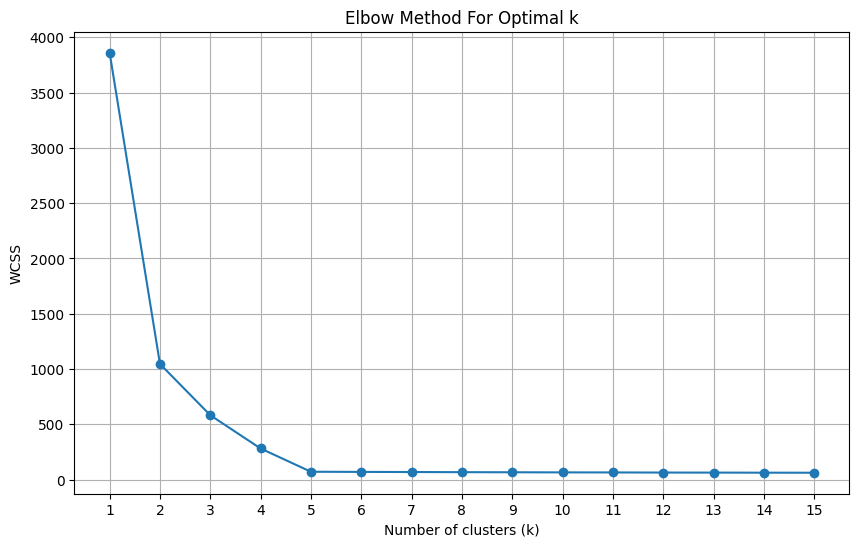

In [16]:
plot_elbow_method(user_characteristics, max_k=15)

In [14]:
cluster_characteristics = kMeans(5, user_characteristics)
generate_playlist_kmeans('1RfKDh', cluster_characteristics, 10)

/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_83799/9861868.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_users_songs ['counts'] = cluster_users_songs ['track_name'].map(song_counts)


,track_name,artists,counts
127403,The Return of the King (feat. Sir James Galway...,Howard Shore,34
3296,Nuovo Cinema Paradiso,Ennio Morricone,27
67159,Caution,The Killers,27
7667,Ode To The Mets,The Strokes,26
57157,In the Blood,John Mayer,26
104780,Gianni Schicchi: O mio babbino caro,Giacomo Puccini,26
7688,Imploding The Mirage,The Killers,26
77199,Dying Breed,The Killers,25
104726,Fawkes the Phoenix,John Williams,25
70157,Reminder,Mumford & Sons,24
